In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import common.data as data
import common.nn as nn

plt.style.use("ggplot")


c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
paths = data.get_dataset_paths("../data")
dataset = data.Marconi100Dataset(paths, data.Scaling.STANDARD)

def dataset_iter():
    for i in range(len(dataset)):
        yield dataset[i]

Loading: 100%|██████████| 249/249 [00:43<00:00,  5.68it/s]


../data\r206n03.gzip


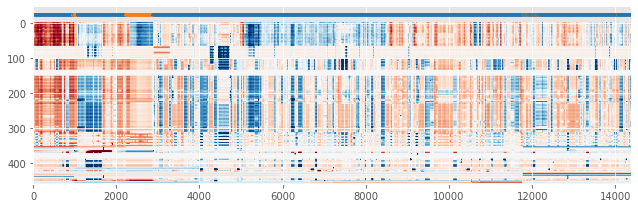

In [4]:
path, hpcsv, labels = dataset[1]

print(path)
nn.plot_dataframe(hpcsv, pd.Series(labels.values))
plt.show()

Num samples: 241
Num time steps: 3270454

min: 1980
max: 20511
mean: 13570.3
median: 13393.0

  < 1024:      0 (0.0%)
 >= 1024:    241 (100.0%)


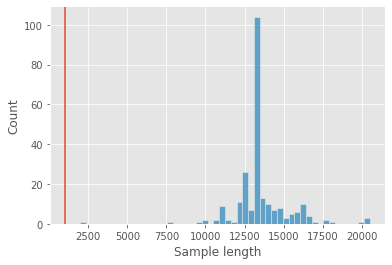

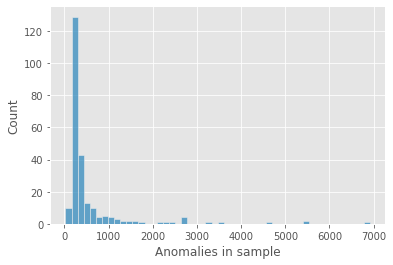

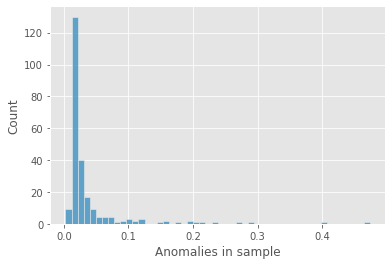

In [9]:
lengths = []
paths = []
anomalies = []
for path, _, labels in dataset_iter():
    paths.append(path)
    lengths.append(len(labels))
    anomalies.append(labels.sum())

num_time_steps = sum(lengths)
min_len = min(lengths)
max_len = max(lengths)
mean_len = np.mean(lengths)
median_len = np.median(lengths)

counter_len = Counter(lengths)
num_samples = len(dataset)
perc_anomal = np.array(anomalies) / np.array(lengths)

perc_anomal_mean = np.mean(perc_anomal)

print(f"Num samples: {num_samples}")
print(f"Num time steps: {num_time_steps}")
print()
print(f"min: {min_len}")
print(f"max: {max_len}")
print(f"mean: {mean_len:.1f}")
print(f"median: {median_len}")

ax = sns.histplot(lengths, bins=50) # type: ignore
ax.set_xlabel("Sample length")

lim = 1024
lt = sum(counter_len[i] for i in range(lim))
lt_p = lt / num_samples * 100
gt = num_samples - lt
gt_p = 100 - lt_p

ax.axvline(lim)
print()
print(f"  < {lim}: {lt:6d} ({lt_p:.1f}%)")
print(f" >= {lim}: {gt:6d} ({gt_p:.1f}%)")
        
plt.show()

ax = sns.histplot(anomalies, bins=50) # type: ignore
ax.set_xlabel("Anomalies in sample")
plt.show()

ax = sns.histplot(perc_anomal, bins=50) # type: ignore
ax.set_xlabel("Anomalies in sample")
plt.show()

Num anomalies: 26037
Num anomalous time steps: 124755
Anomaly ratio: 3.81%

min: 1
max: 5293
mean: 4.8
median: 1.0

  < 4:  24037 (92.3%)
 >= 4:   2000 (7.7%)
>= 10:    435 (1.7%)


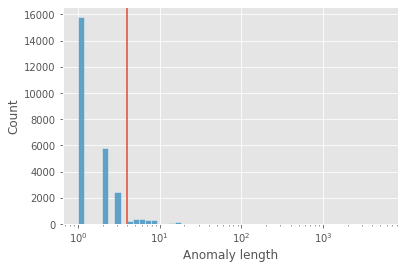

In [10]:
sequences = []
seq_per_sample = []
for _, _, labels in dataset_iter():
    count = 0
    counting = False
    ss = []
    for l in labels:
        if l == 0:
            if counting:
                sequences.append(count)
                ss.append(count)
                count = 0
                counting = False
        else:
            counting = True
            count += 1
    seq_per_sample.append(ss)

num_anomal_ts = sum(sequences)
min_seq = min(sequences)
max_seq = max(sequences)
mean_seq = np.mean(sequences)
median_seq = np.median(sequences)

counter_seq = Counter(sequences)
num_anomalies = len(sequences)

lim = 4
lt = sum(counter_seq[i] for i in range(lim))
lt_p = lt / num_anomalies
gt = num_anomalies - lt
gt_p = 1 - lt_p
gg = sum(counter_seq[i] for i in range(10, max_seq+1))
gg_p = gg / num_anomalies
anomaly_ratio = num_anomal_ts / num_time_steps

ax = sns.histplot(sequences, bins=50, log_scale=True) # type: ignore
ax.set_xlabel("Anomaly length")
ax.axvline(lim)

print(f"Num anomalies: {num_anomalies}")
print(f"Num anomalous time steps: {num_anomal_ts}")
print(f"Anomaly ratio: {anomaly_ratio:.2%}")
print()
print(f"min: {min_seq}")
print(f"max: {max_seq}")
print(f"mean: {mean_seq:.1f}")
print(f"median: {median_seq}")
print()
print(f"  < {lim}: {lt:6d} ({lt_p:.1%})")
print(f" >= {lim}: {gt:6d} ({gt_p:.1%})")
print(f">= 10: {gg:6d} ({gg_p:.1%})")

plt.show()


In [13]:
print()
tol = 0.005
print(f"Samples with perc_anomalies in between [{perc_anomal_mean-tol:.2%}, {perc_anomal_mean+tol:.2%}]")
for path, perc, lens, ss in zip(paths, perc_anomal, lengths, seq_per_sample):
    if perc_anomal_mean - tol < perc < perc_anomal_mean + tol:
        mean_ss = np.mean(ss) if ss else 0
        print(f"{path} - {lens} timesteps - {perc:.2%} anomalies - len seq anomal {mean_ss:.1f}")


Samples with perc_anomalies in between [3.32%, 4.32%]
../data\r207n19.gzip - 14105 timesteps - 3.38% anomalies - len seq anomal 1.7
../data\r210n04.gzip - 16135 timesteps - 4.23% anomalies - len seq anomal 6.8
../data\r213n03.gzip - 13446 timesteps - 3.47% anomalies - len seq anomal 4.1
../data\r213n12.gzip - 13015 timesteps - 3.40% anomalies - len seq anomal 4.3
../data\r216n09.gzip - 16388 timesteps - 3.76% anomalies - len seq anomal 4.9
../data\r229n10.gzip - 13239 timesteps - 4.21% anomalies - len seq anomal 4.6
../data\r233n14.gzip - 15384 timesteps - 3.66% anomalies - len seq anomal 4.8
../data\r240n08.gzip - 12747 timesteps - 3.40% anomalies - len seq anomal 3.0
../data\r245n18.gzip - 13458 timesteps - 3.68% anomalies - len seq anomal 3.9
../data\r245n15.gzip - 14874 timesteps - 4.04% anomalies - len seq anomal 4.7
../data\r248n01.gzip - 12704 timesteps - 3.71% anomalies - len seq anomal 3.9
../data\r250n06.gzip - 13403 timesteps - 3.67% anomalies - len seq anomal 4.1
../data\r